<img src=mainfoto.jpg width=1500px height=300px> 

# <center> <strong> АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

#### <strong> Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные. 

#### <strong> Необходимо проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

#### <strong> A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

## 1. Анализ данных и  их предобработка.

In [37]:
# Импортируем библиотеки для работы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.stats.proportion import proportions_ztest

In [38]:
# Вносим наш датасет в переменную

ab_data = pd.read_csv('ab_data_tourist.csv')
print(ab_data.shape)
ab_data.head(2)


(294478, 5)


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0


Наша таблица представлена следующими полями:

        user_id — идентификатор пользователя, зашедшего на сайт;
        data — дата посещения сайта;
        group — группа теста (контрольная — А или тестовая — B);
        purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
        price — цена купленного тура (если покупка не состоялась, цена равна 0).


Видим, что размер нашего датасета чуть меньше 300 тыс. наблюдений и 5 столбцов, описание которых выше.

In [39]:
# Проверим датасет на наличие пропусков и типа данных в столбцах. 
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


В данных отсутствуют пропуски.

In [40]:
# Преобразуем столбец с датой в формат datetime.
ab_data['date'] = pd.to_datetime(ab_data['date'],format='%Y-%m-%d')
ab_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Дата стоит не по порядку, для дальнейшей работы это необходимо исправить. Отфильтруем дату в порядке убывания.

In [41]:
ab_data.sort_values(by='date',ignore_index=True,inplace=True)
ab_data

,user_id,date,group,purchase,price
0,637212,2021-01-02,B,1,100000
1,924138,2021-01-02,B,0,0
2,659091,2021-01-02,A,0,0
3,653194,2021-01-02,B,0,0
4,810044,2021-01-02,A,0,0
...,...,...,...,...,...
294473,907259,2021-01-24,A,1,60000
294474,820211,2021-01-24,A,0,0
294475,694025,2021-01-24,B,0,0
294476,763379,2021-01-24,B,0,0


Исправили. Для правдоподобности теста необходимо проверить общую длительность каждого теста, что бы все было справедливо и реально.

In [42]:
# Даты начала двух тестов и количество дней процесса
print('количество дней шло тестирование в группе А : {}'.format(ab_data[ab_data['group']=='A']['date'].nunique()))
print('количество дней шло тестирование в группе B : {}'.format(ab_data[ab_data['group']=='B']['date'].nunique()))
print('--------------------------------------------------')
print('дата начала теста')
display(ab_data.groupby('group')['date'].first())
print('     ')
print('дата конца теста')
ab_data.groupby('group')['date'].last()

количество дней шло тестирование в группе А : 23
количество дней шло тестирование в группе B : 23
--------------------------------------------------
дата начала теста


group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

     
дата конца теста


group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

По датасету видно, что тесты проходили в один период времени и одинаковое количество дней. Уточним количество наблюдений в каждой группе.

In [43]:
n_A = ab_data[ab_data['group']=='A'].shape[0]
n_B = ab_data[ab_data['group']=='B'].shape[0]

print('Количество посещений сайта в группе А: {}'.format(n_A))
print('Количество посещений сайта в группе B: {}'.format(n_B))

Количество посещений сайта в группе А: 147202
Количество посещений сайта в группе B: 147276


Составы групп сбалансированы. Проверим, а есть ли пользователи, которые случайным образом попали в обе группы и сколько таких, если имеется?

In [44]:
# Воспользуемся свойством множества и выделим в каждой группе уникальных пользователей, 
unique_user_A = set(ab_data[ab_data['group']=='A']['user_id'])
unique_user_B = set(ab_data[ab_data['group']=='B']['user_id'])

# Дальше проверим пересечение двух групп.
interception_group = unique_user_A.intersection(unique_user_B)
# уточним количество пользователей.
print('Количество пользователей, которые попали в обе группы:', len(interception_group))

Количество пользователей, которые попали в обе группы: 1895


Да уж, действительно такие люди в наших группах присутствуют и не мало. Необходимо удалить таких пользователей с двух групп сразу и записать датасет уже в новую переменную.

In [45]:
ab_data_del_dubl = ab_data[~ab_data['user_id'].isin(interception_group)]

## 2. Первичный анализ результатов A/B-тестирования:

Рассчитаем вспомогательные показатели для контрольной и тестовой групп:

*  количество посещений сайта;
*  суммарное количество совершённых покупок;
*  сумма всех покупок.


In [46]:
# Разобьем наши данные по группам, что бы в дальнейшем было проще к ним обращаться.
group_A = ab_data_del_dubl[ab_data_del_dubl['group']=='A']
group_B = ab_data_del_dubl[ab_data_del_dubl['group']=='B']

In [47]:
ab_table = ab_data_del_dubl.groupby('group'
                         )[['user_id','purchase','price']
                           ].agg(func={'user_id':'count','purchase':'sum','price':'sum'}
                                 ).rename(columns={'user_id':'number_of_visits','purchase':'number_of_purchases','price':'total_sum'})
ab_table

,number_of_visits,number_of_purchases,total_sum
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Видим, что у нас количество посещений почти одинаковое. Количество покупок тоже,но суммы в двух группах разнятся. Это радует, т.к. возможно именно это решит исход данного теста. В общем группы сбалансированы.

В каждой из групп рассчитаем ключевые показатели, из-за которых мы и затеяли данный тест:

*  конверсия;
*  средний чек.


In [48]:
# Конверсия, округленная до двух знаков в процентом соотношении.
ab_table['total_conversion'] = np.round(ab_table['number_of_purchases']*100/ab_table['number_of_visits'],2)

# Средний чек за все время теста.
ab_table['average_test_check'] = np.round(ab_table['total_sum']*100/ab_table['number_of_purchases'])

ab_table


,number_of_visits,number_of_purchases,total_sum,total_conversion,average_test_check
group,,,,,
A,145307,17487,1417780000,12.03,8107623.0
B,145381,17290,1533010000,11.89,8866455.0


Видим, что в первой группе выше показатель конверсии, но ниже показатель среднего чека. Необходимо построить сводную таблицу, где мы наглядно увидим, какие суммы покупок преобладают в каждой группе.

In [49]:
ab_data_del_dubl[ab_data_del_dubl['price']!=0].pivot_table(columns='price',index='group',values='purchase',aggfunc='sum')

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


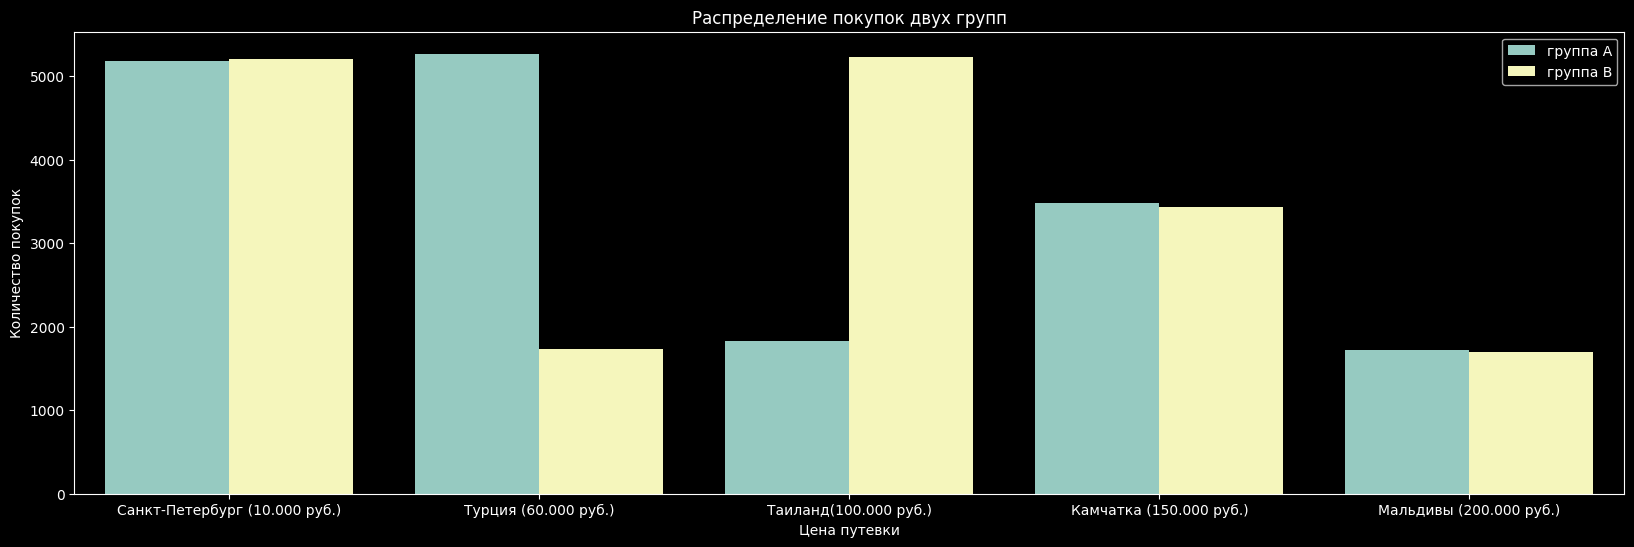

In [50]:
fig,ax = plt.subplots(figsize=(20,6))
sns.countplot(data=ab_data_del_dubl[ab_data_del_dubl['price']!=0],x='price',hue='group')
ax.set_title('Распределение покупок двух групп')
ax.legend(['группа А', 'группа B'])
ax.set_xlabel('Цена путевки')
ax.set_ylabel('Количество покупок');
ax.set_xticks([0,1,2,3,4],['Санкт-Петербург (10.000 руб.)','Турция (60.000 руб.)','Таиланд(100.000 руб.)','Камчатка (150.000 руб.)','Мальдивы (200.000 руб.)'])
plt.show()

На данный момент анализа можно сделать следующие выводы:
1. У нас сбалансированные группы и количества посещений сайта.
2. Конверсия разнится в 1%, причем у первой группы она выше, это говорит о том, что люди чаще покупают путевки.
3. Средний чек нам говорит , что во второй группе, хоть и показатель конверсии ниже, люди больше проводят время на сайте и покупают путевки более дорогие.
4. На графике как раз мы видим где произошел рост покупок. Если в трех из пяти направлениях группы равны в количестве покупок, то разница в количестве покупок путевок за 60 тыс в Турцию и путевок за 100 тыс. в Тайланд разная. Тут у первой группы выделяются путевки более дешевые, а у второй группы мы видим покупки более дорогих.

## 3. Анализ данных на предмет стабилизации метрик:

Нам необходимо проверить комулятивные метрики, как они себя ведут и можно ли считать, что они стабилизировались? A/B-тест завершенным? 


Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:

*  количество посещений страницы;
*  количество покупок;
*  сумму покупок.

 

In [51]:
ab_daily_table = ab_data_del_dubl.groupby(
    ['date','group'],as_index=False)[
        ['user_id','purchase','price']].agg(
            func={'user_id':'count','purchase':'sum','price':'sum'}).rename(
                columns={'user_id':'number_of_visits','purchase':'number_of_purchases','price':'total_sum'})

ab_daily_table.head()


,date,group,number_of_visits,number_of_purchases,total_sum
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000




Рассчитаем кумулятивные показатели:

*  кумулятивное количество посещений страницы;
*  кумулятивное количество покупок;
*  кумулятивную сумму покупок.





<strong>Кумулятивная метрика</strong>  — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

In [52]:
ab_daily_table['comulative_number_of_visits'] = ab_daily_table.groupby('group')['number_of_visits'].cumsum()
ab_daily_table['comulative_number_of_purchases'] = ab_daily_table.groupby('group')['number_of_purchases'].cumsum()
ab_daily_table['comulative_total_sum'] = ab_daily_table.groupby('group')['total_sum'].cumsum()

ab_daily_table.head()

,date,group,number_of_visits,number_of_purchases,total_sum,comulative_number_of_visits,comulative_number_of_purchases,comulative_total_sum
0,2021-01-02,A,2854,359,29410000,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,16016,1906,155660000


Добавляем в нашу таблицу комулятивные данные конверсии и среднего чека. И посмотрим на графике, что у нас получилось.

In [53]:
ab_daily_table['comulative_conversion'] = ab_daily_table['comulative_number_of_purchases']/ab_daily_table['comulative_number_of_visits']
ab_daily_table['comulative_average_check_test'] = ab_daily_table['comulative_total_sum']/ab_daily_table['comulative_number_of_purchases']

ab_daily_table.head()

,date,group,number_of_visits,number_of_purchases,total_sum,comulative_number_of_visits,comulative_number_of_purchases,comulative_total_sum,comulative_conversion,comulative_average_check_test
0,2021-01-02,A,2854,359,29410000,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,9450,1107,91410000,0.117143,82574.525745
3,2021-01-03,B,6619,754,65960000,9480,1099,95620000,0.115928,87006.369427
4,2021-01-04,A,6566,799,64250000,16016,1906,155660000,0.119006,81668.415530


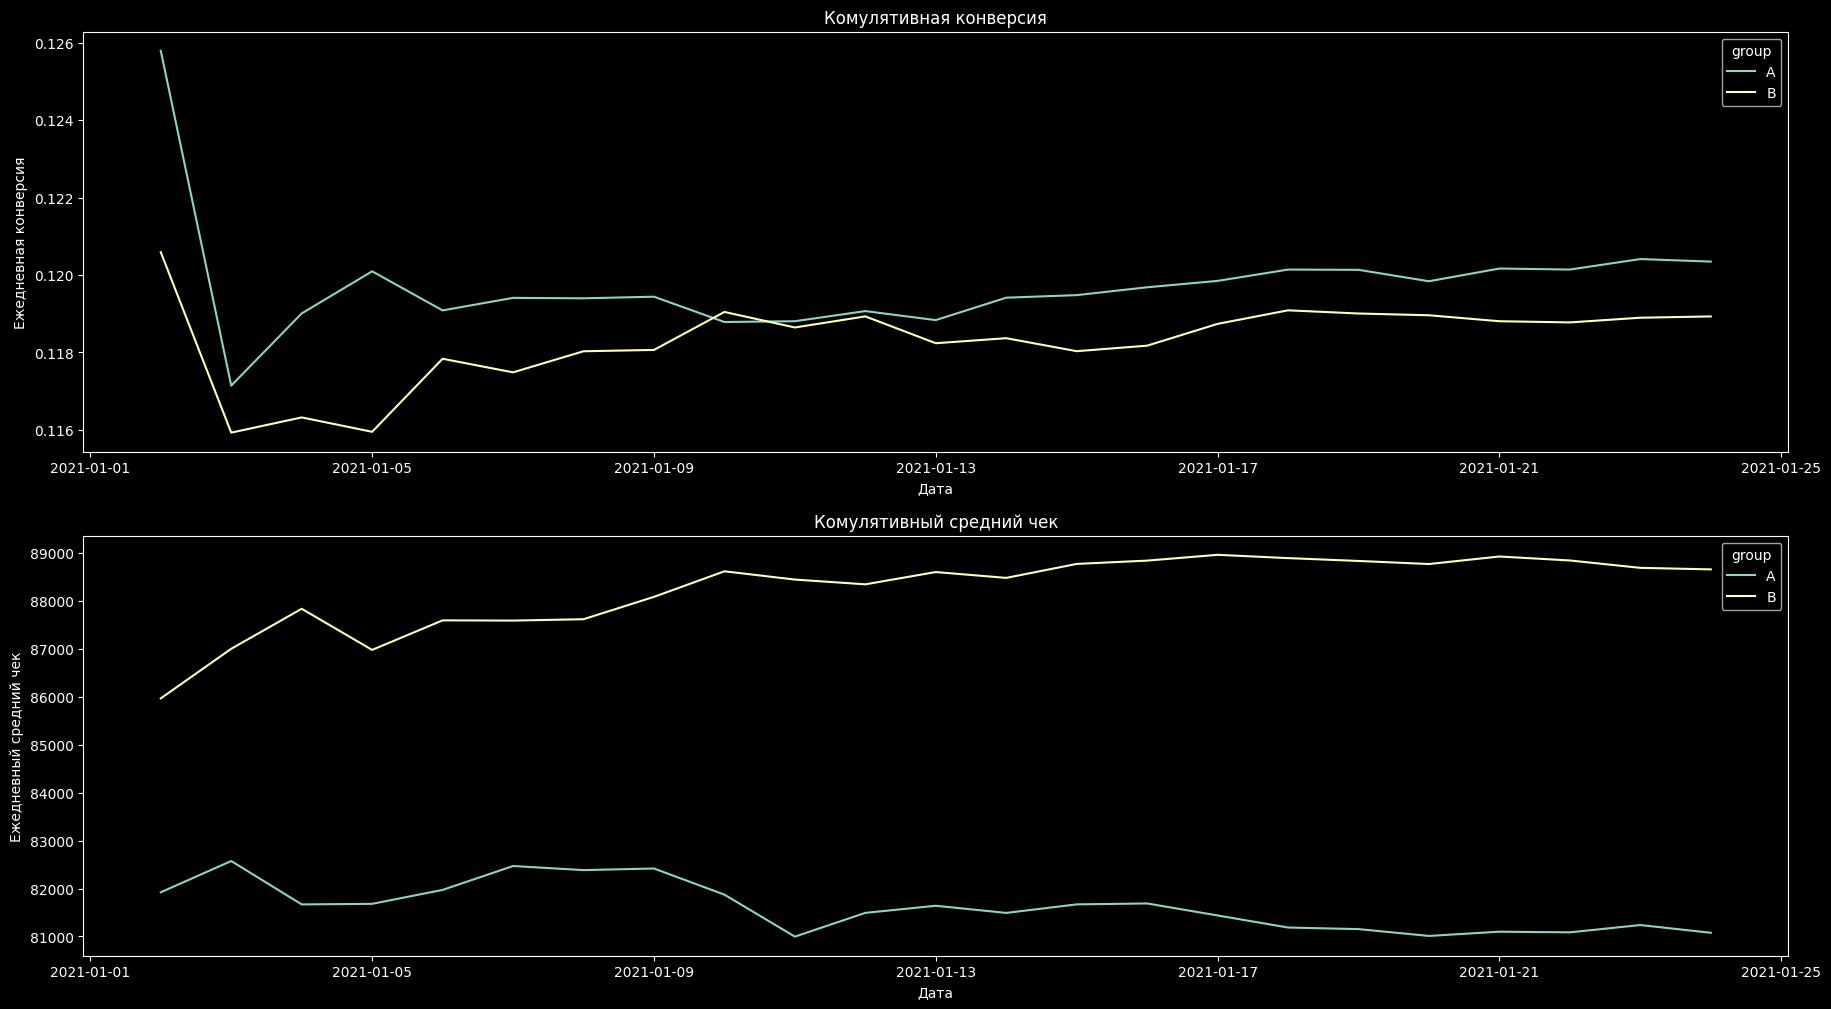

In [54]:
fig,ax = plt.subplots(2,1,figsize = (22,12))
sns.lineplot(ab_daily_table,x='date',y='comulative_conversion',hue='group',ax=ax[0])
ax[0].set_title('Комулятивная конверсия')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Ежедневная конверсия')

sns.lineplot(ab_daily_table,x='date',y='comulative_average_check_test',hue='group',ax=ax[1])
ax[1].set_title('Комулятивный средний чек')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Ежедневный средний чек')
plt.show()

Можем ответить на вопрос, можно ли назвать тест завершенным? Да, можно, метрики стабилизированы. Как и ранее было замечено, конверсия выше в первой группе, а во второй группе выше средний чек.

## 4. Проведение статистического анализа результатов A/B-тестирования:

Итак у нас есть две независимых группы: пользователи в группах A и B не пересекаются. Будем использовать Z-тест для пропорций.

* Нулевая гипотеза: разница пропорций в группах A и B равна некоторому заранее заданному числу value.
#### $$H0: Pa - Pb = value$$ 

* Альтернативная гипотеза: разница пропорций в группах A и B не равна некоторому заранее заданному числу value.
#### $$H1: Pa - Pb \neq value$$ 



